#Using Neural Nets for Image Classification - Part 1

##What you will learn today
1.  Basics of backpropagation - mechanics of implementing gradient descent
2.  Network output layer architecture for multi-class classification
3.  Use of softmax and cross entropy functions
4.  Optimizing network performance

##Order of topics
1.  Back Propagation
2.  Description of MNIST data set
3.  Modifying earlier binary classification problem for multi-class problem
4.  Implementation and optimization of MNIST classifier.

##Pre Reading

https://en.wikipedia.org/wiki/MNIST_database

https://www.youtube.com/watch?v=S75EdAcXHKk - youtube video introducing some of the nets you'll see.

https://github.com/Newmu/Theano-Tutorials - This is the code from the video above.  The code you'll see in class is adapted from the code in this github repo.

https://en.wikipedia.org/wiki/Softmax_function

http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.categorical_crossentropy

##What is Back Propagation?

Previous lectures have talked about using gradient descent to iteratively improve the weights in machine learning models (i.e. train the models).  With neural nets you will hear the terms "back propagation" used in conjunction with weight training.  Backpropagation is basically a bookeeping procedure for efficiently calculating the gradient of error in the network relative to the various weights involved in the neural network.  Backpropagation means calculating the gradient required for gradient descent.  Since you are using Theano for this class, you won't really be required to grind out the details of doing the gradient calculations.  The Theano grad() function will do that for you.  But you will be more comfortable using the system if you understand the basics of backpropagation.  Here is a simple illustration that you can generalize to more realistic cases if required.     

The figure below shows an extrememly simple neural network.  It's a three layer network with input, hidden and output layers.  It has a single neuron in each layer.  The activation functions at each layer and the function for measuring the error between prediction and true labels are left as general functions.  

<img src="files/simpleNN4BkProp.png">

Here are the definitions and equations that go along with the Figure above.  

$x, y$ - input and associated label

$w_i$ - weight on input

$a_h()$ - activation function in first hidden layer

$z_h$ - output of first hidden layer

$w_h$ - weight on hidden layer output

$a_o$ - output layer activation function

$z_o$ - network output

$erf(z_o, y)$ - error function for output and associated label

To perform gradient descent requires the derivatives of the output error with respect to the weight on the input and the weight on the hidden layer output.  What are the equations linking those?  

$z_h = a_h(w_ix)$

$z_o = a_o(w_hz_h)$

The steps through the network represent function composition that has a certain rythm - multiply by a weight, apply activation function, multiply by a weight, apply activation function, repeat.  The repetitions are function composition with the linear function (multiply by a weight) and function composition with the activation function.  Remember that taking the derivative of a composition of functions results in the products of the derivatives of the functions.  So

$\frac{derf}{dw_h} = \frac{derf}{dz_o}\frac{dz_o}{dw_h}$

$ = \frac{derf}{dz_o}\frac{da_o}{d.}z_h$

and look at the relationship between the expression for  $\frac{derf}{dw_h}$ and $\frac{derf}{dw_i}$.

$\frac{derf}{dw_i} = \frac{derf}{dz_o}\frac{da_o}{d.}\frac{dz_h}{dw_i}$

$= \frac{derf}{dz_o}\frac{da_o}{d.}\frac{da_h}{d.}x$

The expression for $\frac{derf}{dw_i}$ begins with the same terms as the expression for $\frac{derf}{dw_h}$.  So it makes sense to compute the derivatives starting at the output layer and working backwards through the network.  That saves recomputing the leading terms in the expression.  That's the essence of backpropagation.  

Q's
1.  Suppose that $a_o$ and $a_h$ are both sigmoid functions ($\frac{1}{(1 + e^{-x})}$)and that the error is the sum squared error.  Use the expressions above to derive the gradient descent equations.  Notice that "sum squared error" implies summing over all the training examples, whereas the equations above, give the gradient contribution from a single training example.

##MNIST Image Data Set
You will see a lot references to the MNIST image data set and you will see the data set used here as examples for image classification.  The MNIST data have played an important role in the progress of neural net technology and are still used as a standard against which new technologies are tested and benchmarked.  MNIST stands for mixed National Institute of Standards and Technology.  It consists of pixelated handwritten digits 0 - 9.  There are 60000 training examples and 10000 test examples.  Each example in the image data consists of 784 real numbers (28 x 28 pixel values) between 0.0 and 1.0 and a label (0 - 9).  The code below reads in the MNIST data and prints the 784 pixel values for the first example from the training set as a 28 x 28 image.  It also prints out the label in one-hot format and the maximum and minimum values from the first example.  The image shows grey-scale values where 1 gets mapped to white and 0 gets mapped to black.  

In [2]:
__author__ = 'mike.bowles'
import numpy as np
import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h


def mnist(ntrain=60000, ntest=10000, onehot=True):
    fd = open('train-images.idx3-ubyte')
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trX = loaded[16:].reshape((60000, 28 * 28)).astype(float)
    
    fd = open('train-labels.idx1-ubyte')
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trY = loaded[8:].reshape((60000))
    
    fd = open('t10k-images.idx3-ubyte')
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teX = loaded[16:].reshape((10000, 28 * 28)).astype(float)
    
    fd = open('t10k-labels.idx1-ubyte')
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teY = loaded[8:].reshape((10000))

    trX = trX / 255.
    teX = teX / 255.

    trX = trX[:ntrain]
    trY = trY[:ntrain]

    teX = teX[:ntest]
    teY = teY[:ntest]

    if onehot:
        trY = one_hot(trY, 10)
        teY = one_hot(teY, 10)
    else:
        trY = np.asarray(trY)
        teY = np.asarray(teY)

    return trX, teX, trY, teY

xTrain, xTest, yTrain, yTest = mnist()


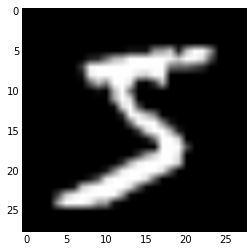

one-hot label =  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
max value =  1.0   min value =  0.0


In [3]:
idx = 0
plt.imshow(xTrain[idx].reshape(28,28), cmap = cm.Greys_r)
plt.show()
print 'one-hot label = ', yTrain[idx]
print 'max value = ', max(xTrain[idx]), '  min value = ', min(xTrain[idx])

##Q's

1.  Pick some different index values in the training set and look at the character image and label to get a feel for the MNIST data set.
2.  Rewrite the code snip to select the test image data and labels and look at a few of those examples. 


##Using Simple two-layer ANN for Classifying MNIST Data
In an earlier lecture you saw a simple neural net used for two-class classification.  In this section, you will see very similar code used to classify the MNIST data.  Below is theano code for a two-layer fully connected network.  It consists of an input layer and an output layer.  Instead of a single output neuron like you saw in the two-class classifier, the MNIST classifier has 10 output neurons.  One neuron to predict each of the digits 0 - 9.  The code below implements sigmoid activation functions for these output neurons and then passes all 10 through a softmax function.  See the wikipedia page for a description of the softmax function.  

https://en.wikipedia.org/wiki/Softmax_function

The softmax function normalizes the values from the 10 output neurons so that they have the properties of a discrete probability distribution - they are all positive numbers and they sum to 1.  Categorical cross entropy is then used to quantify the difference between predicted and actual values.  The one-hot coding for the labels turns the labels into a categorical probability density - one where all the probability mass is concentrated on the label value.  These two probabilities can be compared using cross entropy.  Here's a description of the Theano function for making this comparison. 

http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.categorical_crossentropy

Notice that cross entropy is not a symmetric function of the two probability functions that go into the calculation.  Order matters in the arguments to the function.  

Realization of gradient descent has a couple of differences from the simple example introduced earlier.  One is that this realizaiton does not wait to update the weights until it has run through all of the training examples.  Instead it performs weight updates on what are called "minibatchs" of 128 training examples.  That speeds up the training process.  The minibatch sizes may require some tuning.  Another difference in this realization, is that it is measuring misclassification error on test data - data that were not included in the training examples.  The printout of the training progress is tracking the percentage of examples that are correctly classified.  It's monitoring a different measure of system performance than is being used in the training.  That's because cross entropy is an analytic function that's differentiable and can be used for gradient descent, whereas misclassification error cannot.  On the other hand, misclassification error is a more intuitive measure of classification performance than cross entropy.    

In [7]:
import theano
from theano import tensor as T
import numpy as np
from mnistReader import mnist
from math import sqrt

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    (h, w) = shape
    normalizer = 2.0 * sqrt(6) / sqrt(h + w) * 0.1  #factors: correct for uni[0,1], glo, glo, softmax deriv
    #return theano.shared(floatX(np.random.randn(*shape) * 0.01))  #code for standard initialization
    return theano.shared(floatX((np.random.random_sample(shape) - 0.5) * normalizer))  #code for using Glorot init
    
def model(X, w):
    return T.nnet.softmax(T.dot(X, w))

xTrain, xTest, yTrain, yTest = mnist()
X = T.fmatrix()
Y = T.fmatrix()

w = init_weights((784, 10))

py_x = model(X, w)
y_pred = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
gradient = T.grad(cost=cost, wrt=w)
update = [[w, w - gradient * 0.2]]

train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

for i in range(101):
    for start, end in zip(range(0, len(xTrain), 128), range(128, len(xTrain), 128)):
        cost = train(xTrain[start:end], yTrain[start:end])
    if i % 10 == 0: print i, np.mean(np.argmax(yTest, axis=1) == predict(xTest))


0 0.9056
10 0.9211
20 0.9228
30 0.9237
40 0.9239
50 0.9237
60 0.9236
70 0.9235
80 0.9235
90 0.9236
100 0.9236


##Coding Exercise

1. Implement AdaGrad in place of ordinary gradient descent.  How does that affect the training speed and achievable network performance?

For AdaGrad, AdaDelta, NAG methods you'll need to add some more variables to the update equation.  For example the update rule for AdaGrad at the $n^{th}$ step is:

$\Delta w_n = - \frac{\eta}{\sqrt{\sum_{i = 1}^{n} g_i^2}} g_n$

In this equation $\eta$ is a step size parameter that applies to all the elements of the gradient vector g.  Nothice that the sum of squared past gradients also adjusts the size of the gradient step making the steps smaller as the $g^2$ are accumulated.  But $g^2$ is a vector meaning that different components of the gradient g get different multipliers.  One view of this is that the components that are dominant at the beginning of training are incorporated and then those elements are suppressed allowing for smaller effects to be accumulated.

In order to use AdaGrad, you'll need to accumulate the sum of $g_n^2$.  To do that form a new variable - call it sumG, for example.  Then sumG has a theano update that looks like

$[(sumG, sumG + g^2)]$

This now delivers better numbers than plain gradient descent.  It required some adjustments in order to get performance.  One adjustment was starting the sumG with a small positive number instead of zeros.  The inversion seemed be causing the iteration to diverge.  Another possibility is that the weights aren't being initialized with the Glorot initialization and could be resulting in some saturation leading to very very small gradient values and correspondingly large inverses.  Try changing that to see if it leads to improvement.  

In [10]:
import theano
from theano import tensor as T
import numpy as np
from mnistReader import mnist

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    (h, w) = shape
    normalizer = 2.0 * sqrt(6) / sqrt(h + w) * 0.1  #factors: correct for uni[0,1], glo, glo, softmax deriv
    #return theano.shared(floatX(np.random.randn(*shape) * 0.01))  #code for standard initialization
    return theano.shared(floatX((np.random.random_sample(shape) - 0.5) * normalizer))  #code for using Glorot init
    

def model(X, w):
    return T.nnet.softmax(T.dot(X, w))

xTrain, xTest, yTrain, yTest = mnist()
X = T.fmatrix()
Y = T.fmatrix()

w = init_weights((784, 10))
sumG = theano.shared(np.zeros((784, 10), dtype=theano.config.floatX) + 0.0001)
eta = theano.shared(np.array(0.05, dtype=theano.config.floatX))

py_x = model(X, w)
y_pred = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
gradient = T.grad(cost=cost, wrt=w)
newSumG = sumG + gradient * gradient
rootGSq = T.sqrt(newSumG)
update = [[w, w - eta * gradient / rootGSq], [sumG, sumG + gradient * gradient]]

train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

for i in range(101):
    for start, end in zip(range(0, len(xTrain), 128), range(128, len(xTrain), 128)):
        cost = train(xTrain[start:end], yTrain[start:end])
    if i % 10 == 0: print i, np.mean(np.argmax(yTest, axis=1) == predict(xTest))

0 0.9155
10 0.9254
20 0.9259
30 0.9262
40 0.9268
50 0.927
60 0.9272
70 0.9268
80 0.9269
90 0.9264
100 0.9264


##Discussion of training improvements in Glorot, Bengio paper

The paper that you saw in last lecture highlighted the problems of training multilayer networks and gave several recommendations describing how to avoid these problems.  

http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf

##Q's

1.  What does it mean to say that a neuron with sigmoid activation function is saturated?

2.  Which layers in a deep network are most prone to saturate?

3.  What properties of the weight initialization lead to saturation?

4.  What problems do the authors have with sigmoid non-linearity?

##Coding Homework

The Glorot, Bengio paper suggests that hyperbolic tangent avoids bias issues inherent using the sigmoid function for activation.  It also gives specific numeric recommendations regarding the initialization values for the weights.  Implement one or the other or both of these changes, in addition to using one of the acceleration methods (AdaGrad, AdaDelt, Nesterov, Adam).  How does that affect training speed and network performance.  (Need some volunteers to take various combinations in order to compare.)